# <div align="center">Hello-World-DAC-ADC</div>

### Program the FPGA with the command *cat 4.DAC-ADC.bit > /dev/xdevcfg*

### We use the *periphery module*. 

### The next cell uploads an arbitrary signal of 1024 points to RAM to be generated on DAC1 at a rate of 125 MHz.

### The arbitrary signal has an  amplitude between -1 V and +1 V and a time extension of  1024*8 ns = 8192 ns.

### Connect ADC1 to DAC1.

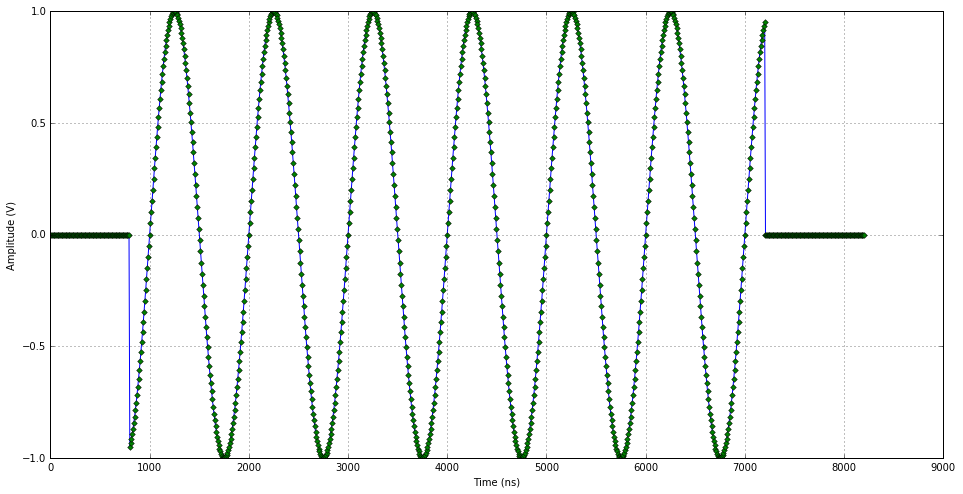

In [4]:
#!/usr/bin/python
###############################################################
PERIOD = 1000 # ns
###############################################################
PERIOD = int(PERIOD/8)
import numpy as np
from periphery import MMIO
from time import *

dat = []
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(0,0)   # Reset port A
regset.write32(0,1)   # Reset port A

for i in range(1024+2):
    y = np.sin(2*np.pi*i/PERIOD)
    if (i <100 or i > 900):
        y=0
    COUNTS = int(y * 2**14/(-2) + 2**13)

    regset.write32(0,COUNTS*256*256+2)
    regset.write32(0,COUNTS*256*256+1+2)
    dat.append(y)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='green', mec='k',ms=4)
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
plt.show()
####################################################################


### The next cell arms the trigger, generates one single instance of the arbitrary signal uploaded above and acquires the signal with Nth_THRESHOLD = 1 and EDGE = 1.

Waiting for trigger ....
Trigger received, pointer at trigger =  645  = 0x285


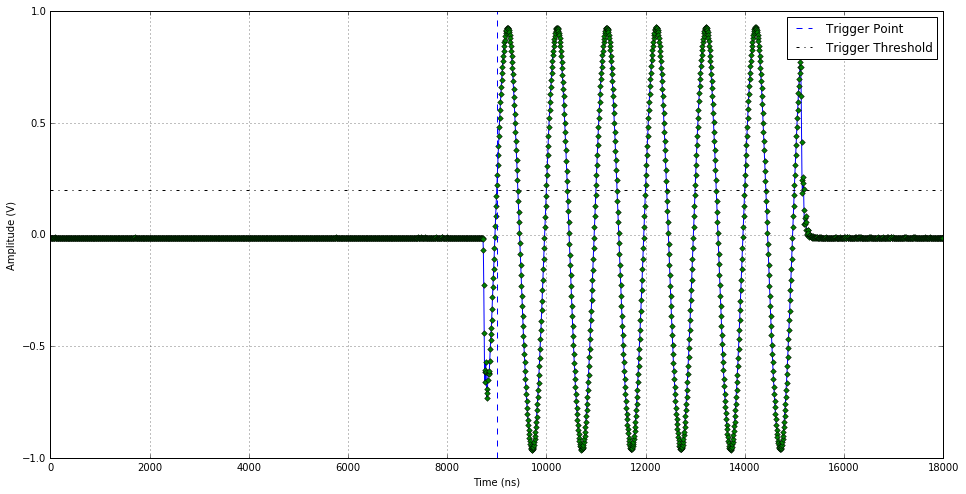

In [8]:
#!/usr/bin/python
import time 
import numpy as np
import random
import matplotlib.pyplot as plt

##########################################################################inputs
CHANNEL = 1 # 1 
GAIN = 1 # +- 1 V
#GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .2 # Volt
POINTS_PLOT_BEFORE_TRIGGER = 9000 # ns
POINTS_SAVE_AFTER_TRIGGER = 9000 # ns
EDGE = 1 # 1 for PosEdge trigger  0 for NegEdge trigger
Nth_THRESHOLD = 1 # Between 1 and 15
#MODE = "AUTO"
MODE = "NORMAL"  # Select one
##########################################################################
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
POINTS_PLOT_BEFORE_TRIGGER = int(POINTS_PLOT_BEFORE_TRIGGER/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
DELAY = 3
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
#print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")
print("Waiting for trigger ....")
from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,Nth_THRESHOLD*256*16  + EDGE) # TRIGGER EDGE and Nth_THRESHOLD
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()

##################################   ASG   ##################################
regset = MMIO(0x41230000, 0xc)
regset.write32(0,0)   # Reset port B
regset.write32(0,4)   # Reset port B
regset.close()
#############################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if MODE == "AUTO":
        ADDR_TRIG_NEW = int (random.random()*2**12)
        break
    
    elif MODE == "NORMAL":
        if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
            break  
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
print("Trigger received, pointer at trigger = ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-POINTS_PLOT_BEFORE_TRIGGER,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='green', mec='k',ms=4)
ax1.axvline(x = (POINTS_PLOT_BEFORE_TRIGGER)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

### The next cell arms the trigger, generates one single instance of the arbitrary signal uploaded above and acquires the signal with Nth_THRESHOLD = 3 and EDGE = 0.

Waiting for trigger ....
Trigger received, pointer at trigger =  1028  = 0x404


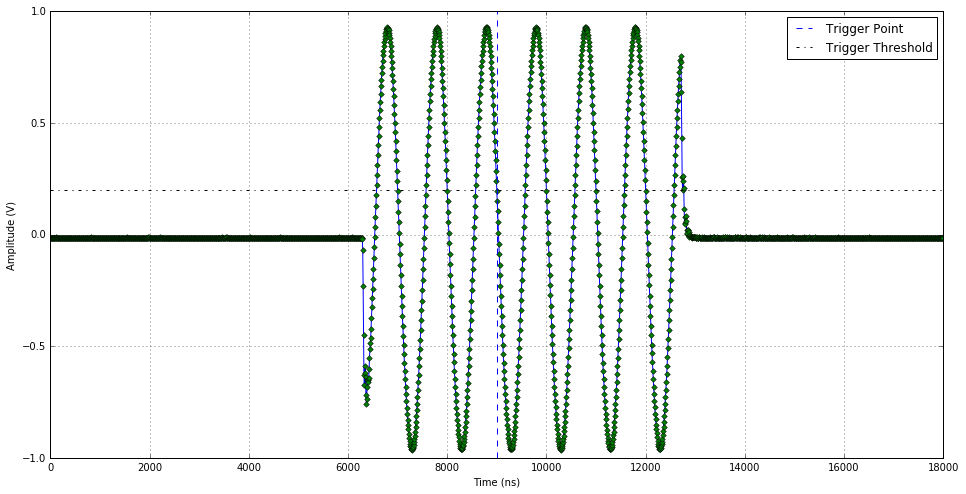

In [9]:
#!/usr/bin/python
import time 
import numpy as np
import random
import matplotlib.pyplot as plt

##########################################################################inputs
CHANNEL = 1 # 1 
GAIN = 1 # +- 1 V
#GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .2 # Volt
POINTS_PLOT_BEFORE_TRIGGER = 9000 # ns
POINTS_SAVE_AFTER_TRIGGER = 9000 # ns
EDGE = 0 # 1 for PosEdge trigger  0 for NegEdge trigger
Nth_THRESHOLD = 3 # Between 1 and 15
#MODE = "AUTO"
MODE = "NORMAL"  # Select one
##########################################################################
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
POINTS_PLOT_BEFORE_TRIGGER = int(POINTS_PLOT_BEFORE_TRIGGER/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
DELAY = 3
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
#print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")
print("Waiting for trigger ....")
from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,Nth_THRESHOLD*256*16  + EDGE) # TRIGGER EDGE and Nth_THRESHOLD
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()

##################################   ASG   ##################################
regset = MMIO(0x41230000, 0xc)
regset.write32(0,0)   # Reset port B
regset.write32(0,4)   # Reset port B
regset.close()
#############################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if MODE == "AUTO":
        ADDR_TRIG_NEW = int (random.random()*2**12)
        break
    
    elif MODE == "NORMAL":
        if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
            break  
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
print("Trigger received, pointer at trigger = ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-POINTS_PLOT_BEFORE_TRIGGER,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='green', mec='k',ms=4)
ax1.axvline(x = (POINTS_PLOT_BEFORE_TRIGGER)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

### We  replot the last plot using Plotly.  

### To install Plotly execute *sudo pip3 install plotly* on a terminal of the RedPitaya.

In [49]:
import plotly
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y,mode='lines+markers',
    line=dict(color="blue",  width=2),
    marker=dict(color="green", size=5)))
fig.update_layout(
    title="Nth-Threshold-Trigger-Acquire",
    xaxis_title="Time (ns)",
    yaxis_title="Amplitude (V)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"))
fig.add_vline(x=(POINTS_PLOT_BEFORE_TRIGGER)*8, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=TRESHOLD_VOLT, line_width=1, line_dash="dash", line_color="blue")

fig.show()

### Let's do another arbitrary signal.

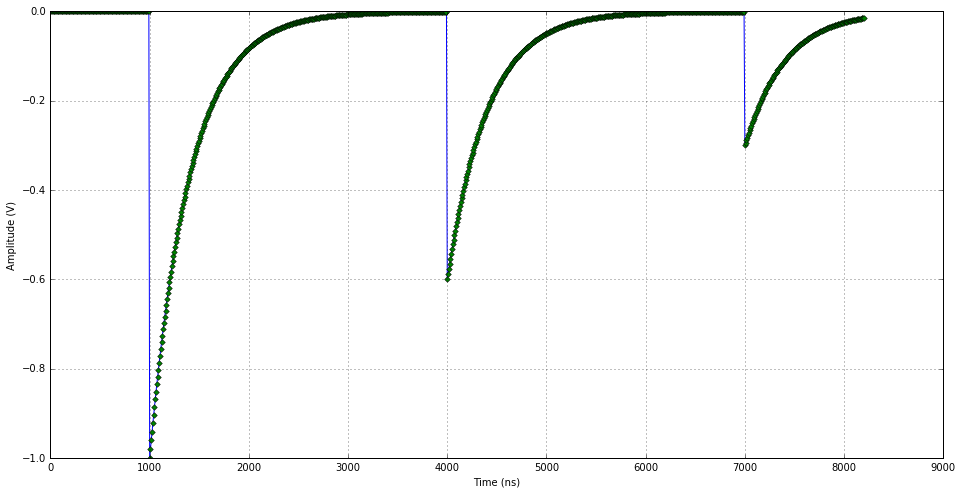

In [11]:
#!/usr/bin/python
###############################################################
PERIOD = 1000 # ns
###############################################################
PERIOD = int(PERIOD/8)
import numpy as np
from periphery import MMIO
from time import *

dat = []
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(0,0)   # Reset port A
regset.write32(0,1)   # Reset port A


w = 2**10  * 8 # = 8192 ns
tau = 400 # ns
x0 = 1000 # ns
x1 = 4000 # ns
x2 = 7000 # ns
tau = int(tau/8)
x0 = int(x0/8)
x1 = int(x1/8)
x2 = int(x2/8)

for i in range(1024+2):
    if i<x0:y = 0
    elif i<x1:y = -1*np.exp(-(i-x0)/tau) 
    elif i<x2: y = -.6*np.exp(-(i-x1)/tau) 
    elif i<w: y = -.3*np.exp(-(i-x2)/tau)
    COUNTS = int(y * 2**14/(-2) + 2**13)
    #print(COUNTS,end = " ")
    regset.write32(0,COUNTS*256*256+2)
    regset.write32(0,COUNTS*256*256+1+2)
    dat.append(y)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='green', mec='k',ms=4)
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
plt.show()
####################################################################


### The next cell arms the trigger, generates one single instance of the arbitrary signal uploaded above and acquires the signal with Nth_THRESHOLD = 2 and EDGE = 0.

Waiting for trigger ....
Trigger received, pointer at trigger =  1540  = 0x604


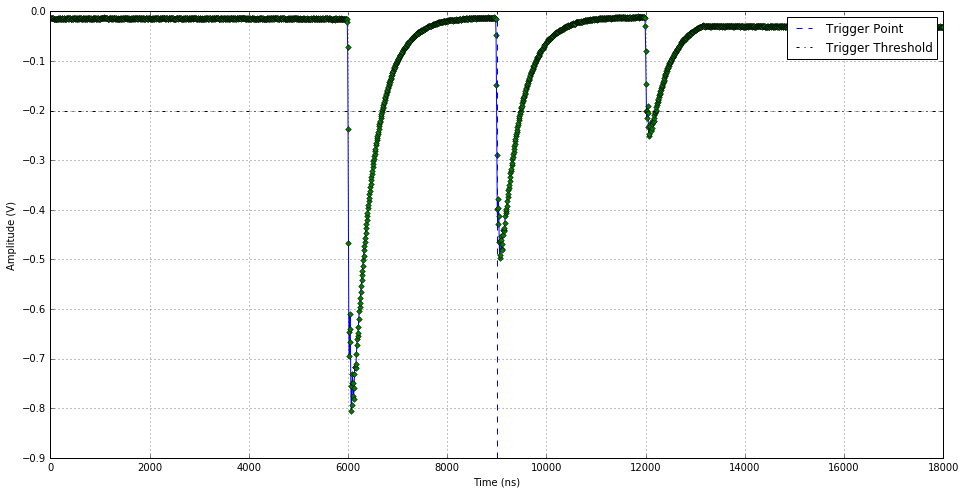

In [12]:
#!/usr/bin/python
import time 
import numpy as np
import random
import matplotlib.pyplot as plt

##########################################################################inputs
CHANNEL = 1 # 1 
GAIN = 1 # +- 1 V
#GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = -.2 # Volt
POINTS_PLOT_BEFORE_TRIGGER = 9000 # ns
POINTS_SAVE_AFTER_TRIGGER = 9000 # ns
EDGE = 0 # 1 for PosEdge trigger  0 for NegEdge trigger
Nth_THRESHOLD = 2 # Between 1 and 15
#MODE = "AUTO"
MODE = "NORMAL"  # Select one
##########################################################################
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
POINTS_PLOT_BEFORE_TRIGGER = int(POINTS_PLOT_BEFORE_TRIGGER/8)
#POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE
DELAY = 3
TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
#print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")
print("Waiting for trigger ....")
from periphery import MMIO
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,Nth_THRESHOLD*256*16  + EDGE) # TRIGGER EDGE and Nth_THRESHOLD
regset.close()

####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256) - DELAY
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()

##################################   ASG   ##################################
regset = MMIO(0x41230000, 0xc)
regset.write32(0,0)   # Reset port B
regset.write32(0,4)   # Reset port B
regset.close()
#############################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256) - DELAY
    if MODE == "AUTO":
        ADDR_TRIG_NEW = int (random.random()*2**12)
        break
    
    elif MODE == "NORMAL":
        if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
            break  
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
print("Trigger received, pointer at trigger = ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-POINTS_PLOT_BEFORE_TRIGGER,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='green', mec='k',ms=4)
ax1.axvline(x = (POINTS_PLOT_BEFORE_TRIGGER)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

### Note that the DAC keeps sending the last number of the arbitrary signal uploaded, which in this case was different  from zero.